In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

path = "Dataset" 
labelFile = 'labels.csv' 
batch_size_val = 32 
epochs_val = 10
imageDimesions = (32,32,3)
testRatio = 0.2    
validationRatio = 0.2 


In [2]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        curImg = cv2.resize(curImg, (imageDimesions[0], imageDimesions[1]))
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 16
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15  


In [3]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

print("Data Shapes") 
print("Train",end = "");print(X_train.shape,y_train.shape) 
print("Validation",end = "");print(X_validation.shape,y_validation.shape) 
print("Test",end = "");print(X_test.shape,y_test.shape)


Data Shapes
Train(13497, 32, 32, 3) (13497,)
Validation(3375, 32, 32, 3) (3375,)
Test(4218, 32, 32, 3) (4218,)


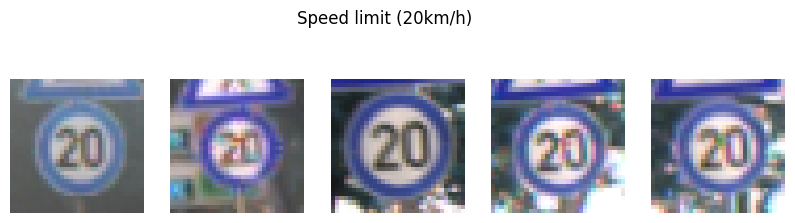

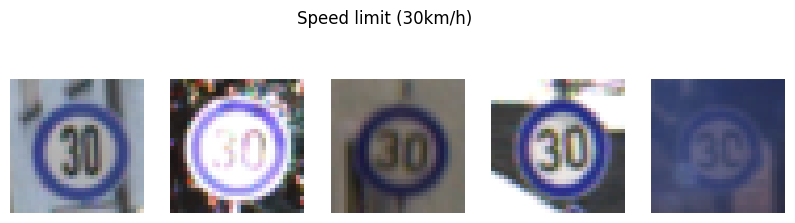

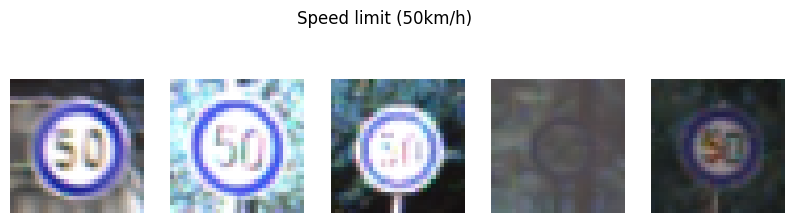

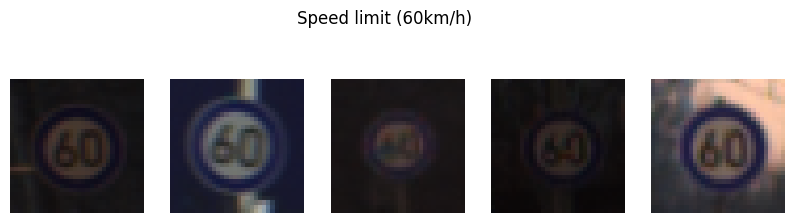

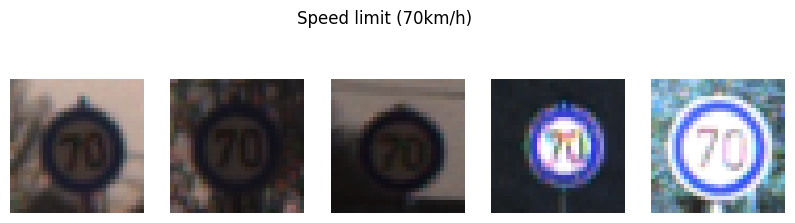

In [4]:
data=pd.read_csv(labelFile)
 
num_classes = noOfClasses

for i in range(noOfClasses):
    folder_path = os.path.join(path, str(i))

num_to_show = 5
label_names = data["Name"].values  
for i in range(num_to_show):
    folder_path = os.path.join(path, str(i))
    img_list = os.listdir(folder_path)
    random_imgs = random.sample(img_list, 5)  

    plt.figure(figsize=(10, 3))
    for j, img_name in enumerate(random_imgs):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, j + 1)
        plt.imshow(img)
        plt.axis('off')

    label = label_names[i] if i < len(label_names) else f"Label {i}"
    plt.suptitle(label, fontsize=12, y=0.95)

    plt.show()

In [5]:
# --- CELL 6: Tiền xử lý ảnh ---
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     
    img = equalize(img)      
    img = img/255            
    return img

X_train=np.array(list(map(preprocessing,X_train)))  
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)


In [6]:
# Tính số lượng ảnh của mỗi lớp
class_counts = pd.Series(classNo).value_counts().sort_index()
avg_count = int(class_counts.mean())

# Transform tăng cường cho các lớp ít ảnh
augment_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=0.1, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Transform cơ bản cho lớp đủ ảnh
basic_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Tạo danh sách ảnh và nhãn sau tăng cường
aug_images = []
aug_labels = []

for cls in range(noOfClasses):
    cls_indices = np.where(y_train == cls)[0]
    count_cls = len(cls_indices)
    needed = max(0, avg_count - count_cls)  # số ảnh cần thêm
    cls_imgs = X_train[cls_indices]

    for img in cls_imgs:
        aug_images.append(img)
        aug_labels.append(cls)

    if needed > 0:
        for i in range(needed):
            img = random.choice(cls_imgs)
            img = augment_transform(img)
            img = (img.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
            aug_images.append(img)
            aug_labels.append(cls)

aug_images = np.array(aug_images)
aug_labels = np.array(aug_labels)

# Shuffle lại để tránh bias
shuffle_idx = np.random.permutation(len(aug_images))
aug_images = aug_images[shuffle_idx]
aug_labels = aug_labels[shuffle_idx]

# Dataset tuỳ chỉnh
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32)
        img = np.squeeze(img)
        img = Image.fromarray((img * 255).astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Dataloader (augmentation cho train, bình thường cho val/test)
train_dataset = CustomDataset(aug_images, aug_labels, transform=transforms.ToTensor())
val_dataset = CustomDataset(X_validation, y_validation, transform=transforms.ToTensor())
test_dataset = CustomDataset(X_test, y_test, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False)


In [7]:
class MyModel(nn.Module):
    def __init__(self, noOfClasses):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 60, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(60, 60, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(60, 30, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(30, 30, kernel_size=3, padding=1)
        self.drop = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(30 * 8 * 8, 500)
        self.fc2 = nn.Linear(500, noOfClasses)
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = self.drop(x)
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel(noOfClasses).to(device)

print(model)


MyModel(
  (conv1): Conv2d(1, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(60, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(60, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1920, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=16, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(epochs_val):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total

    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

In [9]:
torch.save(model.state_dict(), "model1.pth")


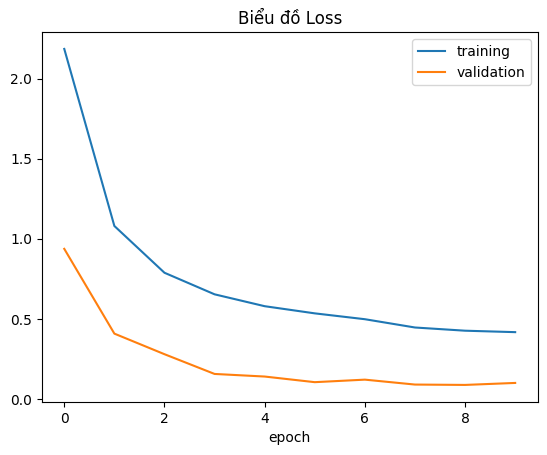

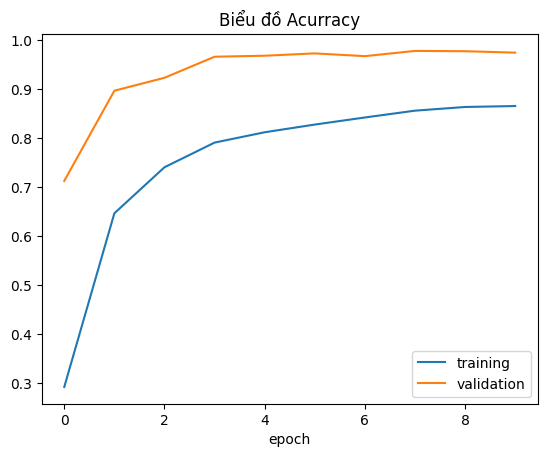

In [9]:
plt.figure(1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['training','validation'])
plt.title('Biểu đồ Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Biểu đồ Acurracy')
plt.xlabel('epoch')
plt.show()


<Figure size 1000x800 with 0 Axes>

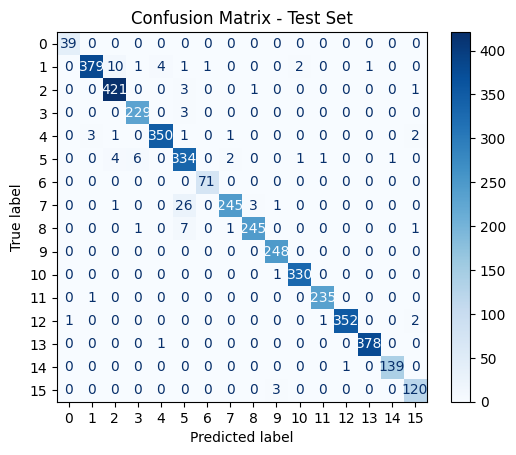

In [10]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_loss /= len(test_loader)
test_acc = correct / total 

print('Train Accuracy:', train_acc)
print('Test Accuracy:', test_acc)


Train Accuracy: 0.8647097875569044
Test Accuracy: 0.9755808440018966
